In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
import itertools
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from functions import *
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable



In [ ]:
# cluster_map = pd.read_csv('plotting_script/data/cluster_info.tsv', sep='\t')

# dle_info = pd.read_csv('plotting_script/data/protein_info.tsv', sep='\t')

# # display(cluster_map.head(), dle_info.head())

In [ ]:
# merged_df = dle_info.merge(cluster_map, on='Uniref', how='left')

# display(merged_df.head())


In [ ]:
# merged_df.drop(merged_df.columns[6], axis=1, inplace=True)
# merged_df.drop(merged_df.columns[6], axis=1, inplace=True)

# display(merged_df.head())



In [29]:
# merged_df.to_csv('plotting_script/data/merged_info.tsv', sep='\t', index=False)

In [12]:
merged_df = pd.read_csv('plotting_script/data/merged_info.tsv', sep='\t')

In [13]:
# Calculate the occurrence of each domain in each cluster
domain_occurrences = defaultdict(lambda: defaultdict(int))
total_domains_per_cluster = defaultdict(int)

for index, row in merged_df.iterrows():
    cluster_id = row['dl_endopeptidase-foldseek_cluster']
    domains = row['Interpro']
    
    if pd.notnull(domains):
        for domain in eval(domains):
            domain_occurrences[cluster_id][domain] += 1
            total_domains_per_cluster[cluster_id] += 1

# Calculate the percentage of each domain in each cluster
domain_percentages = {cluster: {domain: count / total_domains_per_cluster[cluster] 
                                for domain, count in domains.items()} 
                      for cluster, domains in domain_occurrences.items()}

# Convert domain percentages to a matrix for similarity calculation
# Create a list of all unique domains across all clusters
all_domains = set(domain for cluster_domains in domain_percentages.values() for domain in cluster_domains.keys())

# Create a matrix of domain percentages for each cluster
cluster_ids = list(domain_percentages.keys())
domain_matrix = np.zeros((len(cluster_ids), len(all_domains)))

# Mapping of cluster IDs and domain indices to facilitate matrix population
cluster_idx_map = {cluster_id: idx for idx, cluster_id in enumerate(cluster_ids)}
domain_idx_map = {domain: idx for idx, domain in enumerate(all_domains)}

# Populate the matrix with domain percentages
for cluster_id, domains in domain_percentages.items():
    for domain, percentage in domains.items():
        cluster_idx = cluster_idx_map[cluster_id]
        domain_idx = domain_idx_map[domain]
        domain_matrix[cluster_idx, domain_idx] = percentage

# Calculate cosine similarity between clusters based on domain matrix
cosine_sim = cosine_similarity(domain_matrix)

# Convert the similarity matrix to edge list for significant similarities
# We consider a similarity significant if it's above 0.1 (can adjust)
significant_similarity_threshold = 0.1
significant_edges = [(cluster_ids[i], cluster_ids[j], cosine_sim[i, j]) 
                     for i in range(len(cluster_ids)) 
                     for j in range(i+1, len(cluster_ids)) 
                     if cosine_sim[i, j] > significant_similarity_threshold]

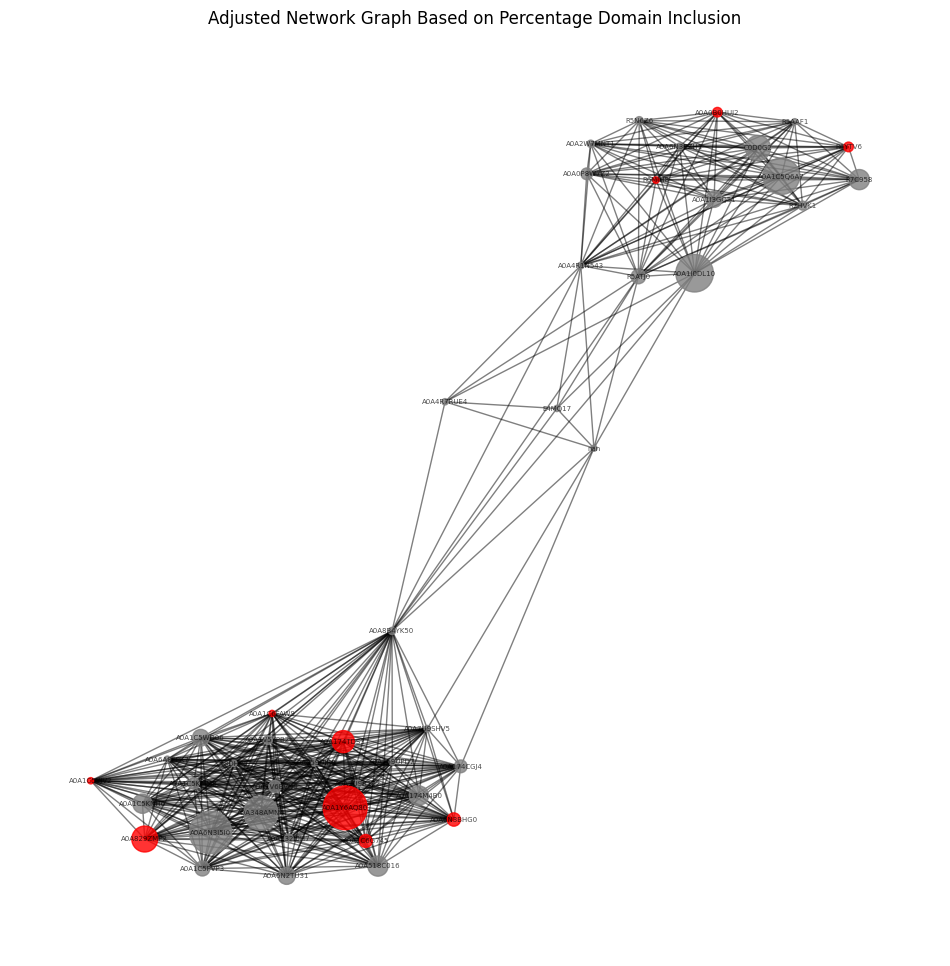

In [17]:

# Create the network graph
G_adjusted_similarity = nx.Graph()

# Add nodes (clusters)
G_adjusted_similarity.add_nodes_from(cluster_ids)

# Add edges with weights based on cosine similarity
G_adjusted_similarity.add_weighted_edges_from(significant_edges)

downregulated_clusters = [
    "A0A1C6G745",
    "A0A829ZMP2",
    "A0A1C6FAW9",
    "A0A174TDS3",
    "R6MIH8",
    "A0A1C5VJV2",
    "A0A0B0HUJ2",
    "R6YTV6",
    "A0A1Y6AQ80",
    "A0A6N3BHG0"
]

# Assign colors to nodes based on whether they are downregulated in CRC
node_colors = ["red" if node in downregulated_clusters else "Grey" for node in G_adjusted_similarity.nodes()]

# Step 1: Calculate the size of each cluster
cluster_sizes = merged_df['dl_endopeptidase-foldseek_cluster'].value_counts().to_dict()

# Step 2: Map cluster sizes to node sizes for visualization
# Normalize cluster sizes to a suitable range for node sizes in the graph (e.g., between 20 and 1000)
min_size = 20
max_size = 1000
min_cluster_size = min(cluster_sizes.values())
max_cluster_size = max(cluster_sizes.values())
node_sizes = [
    ((cluster_sizes[node] - min_cluster_size) / (max_cluster_size - min_cluster_size) * (max_size - min_size) + min_size)
    if node in cluster_sizes else min_size
    for node in G_adjusted_similarity.nodes()
]

# Visualize the adjusted network
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_adjusted_similarity, seed=42)  # For consistent layout

# Draw the network
nx.draw_networkx_nodes(G_adjusted_similarity, pos, node_color=node_colors, node_size=node_sizes, alpha=0.8)
nx.draw_networkx_edges(G_adjusted_similarity, pos, alpha=0.5)
nx.draw_networkx_labels(G_adjusted_similarity, pos, font_size=5, alpha=0.7)

plt.title("Adjusted Network Graph Based on Percentage Domain Inclusion")
plt.axis('off')
plt.savefig('../../figures/adjusted_network.png', dpi=600, bbox_inches='tight')

In [7]:
display(merged_df.head())

,# ID,Genome,Prediction,Uniref,Lineage,Interpro,dl_endopeptidase-foldseek_cluster
0,MGYG000155050_27_22,MGYG000155050,OTHER,A0A3S5AQD8,d__Bacteria;p__Firmicutes;c__Bacilli;o__RFN20;...,"['Endopeptidase, NLPC/P60 domain']",A0A1C5WD06
1,MGYG000096674_74_7,MGYG000096674,OTHER,A0A1C6G2Q5,d__Bacteria;p__Firmicutes;c__Bacilli;o__RFN20;...,"['Endopeptidase, NLPC/P60 domain']",A0A1C5WD06
2,MGYG000074457_25_259,MGYG000074457,SP,A0A3P1BK63,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacill...,"['Endopeptidase, NLPC/P60 domain', 'SH3-like d...",A0A1V6BVN9
3,MGYG000074457_44_345,MGYG000074457,SP,A0A2S9XVU2,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacill...,"['Endopeptidase, NLPC/P60 domain', 'Bacterial ...",A0A1V5YPB2
4,MGYG000002288_3_33,MGYG000002288,SP,A0A3P1BK63,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacill...,"['Endopeptidase, NLPC/P60 domain', 'SH3-like d...",A0A1V6BVN9


In [ ]:
# cluster_df = merged_df.groupby('dl_endopeptidase-foldseek_cluster')['Uniref'].count()
# print(cluster_df)


cluster_df = merged_df.groupby('dl_endopeptidase-foldseek_cluster')['Uniref'].count().sort_values(ascending=False)
# print(cluster_df)

cluster_df = pd.DataFrame(cluster_df).reset_index()

cluster_df = cluster_df.rename(columns={'dl_endopeptidase-foldseek_cluster': 'Cluster', 'Uniref': 'Counts'})

downregulated_clusters = [
    "A0A1C6G745",
    "A0A829ZMP2",
    "A0A1C6FAW9",
    "A0A174TDS3",
    "R6MIH8",
    "A0A1C5VJV2",
    "A0A0B0HUJ2",
    "R6YTV6",
    "A0A1Y6AQ80",
    "A0A6N3BHG0"
]



plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(cluster_df['Counts'], bins=40, edgecolor='black')

# Calculate the maximum frequency 
max_frequency = max(n)

# Manage overlapping annotations by tracking the y-positions used
y_positions = {}

# Annotating specific cluster IDs
for cluster in downregulated_clusters:
    count = cluster_df.loc[cluster_df['Cluster'] == cluster, 'Counts'].values[0]
    bin_index = (count - bins[0]) // (bins[1] - bins[0])
    bin_height = n[int(bin_index)]
    base_y_position = bin_height + 0.05 * max_frequency  # Initial position above the bin

    # Adjust y position if there is an overlap
    position_adjusted = False
    while not position_adjusted:
        if base_y_position in y_positions and abs(y_positions[base_y_position] - count) < 100:
            base_y_position += 0.05 * max_frequency  # Increment to avoid overlap
        else:
            y_positions[base_y_position] = count
            position_adjusted = True

    # Add annotation with an arrow
    plt.annotate(cluster, (count, bin_height), xytext=(count, base_y_position),
                 arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), ha='center')

plt.title('Histogram of Protein Cluster Sizes with Annotations')
plt.xlabel('Counts')
plt.ylabel('Frequency')
plt.show()




In [4]:
ibd_maaslin = pd.read_csv('/Volumes/PGH-Backup/ibd_data/maaslin2/maaslin2_results_ibd/all_results.tsv', sep='\t')

display(ibd_maaslin.head()) 

,feature,metadata,value,coef,stderr,N,N.not.0,pval,qval
0,DL.endopeptidase.A0A564W7U7,diagnosis,CD,-2.042184e-06,3.373508e-07,1316,1137,1.845662e-09,6.455021e-08
1,DL.endopeptidase.R7C958,diagnosis,CD,-5.649543e-07,9.419367e-08,1316,311,2.582008e-09,6.455021e-08
2,DL.endopeptidase.A0A1C5WD06,diagnosis,CD,-7.977376e-06,1.636441e-06,1316,1187,1.221817e-06,1.527272e-05
3,DL.endopeptidase.A0A6N2TU31,diagnosis,CD,3.413572e-06,6.965349e-07,1316,658,1.073461e-06,1.527272e-05
4,DL.endopeptidase.A0A1C5KMM8,diagnosis,CD,-8.097945e-06,1.717678e-06,1316,1211,2.681634e-06,2.681634e-05


In [5]:
df_cd = ibd_maaslin[ibd_maaslin['value'] == 'CD']
df_uc = ibd_maaslin[ibd_maaslin['value'] == 'UC']

df_cd = scale_values(df_cd)
df_uc = scale_values(df_uc)

df_cd['feature'] = df_cd['feature'].str.split('.').str[2]
df_uc['feature'] = df_uc['feature'].str.split('.').str[2]

display(df_cd)

/Users/odesa/Developer/CRC-Final/src/clustering/functions.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['scaled_value'] = -np.log(dataframe['qval']) * np.sign(dataframe['coef'])
/Users/odesa/Developer/CRC-Final/src/clustering/functions.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['scaled_value'] = -np.log(dataframe['qval']) * np.sign(dataframe['coef'])


,feature,metadata,value,coef,stderr,N,N.not.0,pval,qval,scaled_value
0,A0A564W7U7,diagnosis,CD,-2.042184e-06,3.373508e-07,1316,1137,1.845662e-09,6.455021e-08,-16.555822
1,R7C958,diagnosis,CD,-5.649543e-07,9.419367e-08,1316,311,2.582008e-09,6.455021e-08,-16.555822
2,A0A1C5WD06,diagnosis,CD,-7.977376e-06,1.636441e-06,1316,1187,1.221817e-06,1.527272e-05,-11.089443
4,A0A1C5KMM8,diagnosis,CD,-8.097945e-06,1.717678e-06,1316,1211,2.681634e-06,2.681634e-05,-10.526499
11,A0A6N3BHG0,diagnosis,CD,-4.621764e-06,1.361768e-06,1316,826,7.094738e-04,2.956141e-03,-5.823871
13,A0A1C5Q6A7,diagnosis,CD,-1.115849e-06,3.703661e-07,1316,640,2.637826e-03,9.420806e-03,-4.664835
18,R5N6Z6,diagnosis,CD,-4.275666e-07,1.623004e-07,1316,246,8.527382e-03,2.427929e-02,-3.718132
25,A0A1C5VJV2,diagnosis,CD,-8.769410e-08,4.403737e-08,1316,147,4.664863e-02,8.970891e-02,-2.411185
28,A0A174M4B0,diagnosis,CD,-1.082212e-06,5.841671e-07,1316,929,6.416791e-02,1.106343e-01,-2.201525
29,R5ATJ0,diagnosis,CD,-3.358063e-07,1.955232e-07,1316,194,8.612808e-02,1.435468e-01,-1.941094


In [8]:
-np.log(0.05)

2.995732273553991

In [16]:
def plot_network(cluster_ids, significant_edges, association_table, merged_df, title):

    """ Plot the network graph with adjusted node colors and sizes based on association
        values and cluster sizes, respectively. Scale the node colour based on the
        association with the given feature. """
    
    # Make association dict
    association_dict = dict(zip(association_table['feature'], association_table['scaled_value']))

    # Create the network graph
    G_adjusted_similarity = nx.Graph()

    # Add nodes (clusters)
    G_adjusted_similarity.add_nodes_from(cluster_ids)

    # Add edges with weights based on cosine similarity
    G_adjusted_similarity.add_weighted_edges_from(significant_edges)

    # Define color scaling function
    def get_node_color(node):
        if node in association_dict:
            value = association_dict[node]
            return value
        else:
            return None

    # Assign colors to nodes based on their association values
    node_values = [get_node_color(node) for node in G_adjusted_similarity.nodes()]
    abs_max_val = max(abs(val) for val in node_values if val is not None)
    min_val = -abs_max_val
    max_val = abs_max_val
    reversed_bwr = plt.cm.bwr.reversed()  # Reverse the colormap

    node_colors = [
        'grey' if value is None or -3 < value < 3 else reversed_bwr((value - min_val) / (max_val - min_val))
        for value in node_values   
    ]

    # Calculate the size of each cluster
    cluster_sizes = merged_df['dl_endopeptidase-foldseek_cluster'].value_counts().to_dict()

    # Normalize cluster sizes to a suitable range for node sizes in the graph
    min_size = 20
    max_size = 1000
    min_cluster_size = min(cluster_sizes.values())
    max_cluster_size = max(cluster_sizes.values())
    node_sizes = [
        ((cluster_sizes[node] - min_cluster_size) / (max_cluster_size - min_cluster_size) * (max_size - min_size) + min_size)
        if node in cluster_sizes else min_size
        for node in G_adjusted_similarity.nodes()
    ]

    # Visualize the adjusted network
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G_adjusted_similarity, seed=42)  # For consistent layout

    # Draw the network
    nodes = nx.draw_networkx_nodes(G_adjusted_similarity, pos, node_color=node_colors, node_size=node_sizes, alpha=0.8, cmap=plt.cm.bwr)
    nx.draw_networkx_edges(G_adjusted_similarity, pos, alpha=0.5)
    nx.draw_networkx_labels(G_adjusted_similarity, pos, font_size=5, alpha=0.7)

    if title is not None:
        plt.title(title)
    else:
        plt.title("Adjusted Network Graph Based on Percentage Domain Inclusion")
        plt.axis('off')

    # Create a ScalarMappable for the colorbar
    sm = ScalarMappable(cmap=reversed_bwr, norm=Normalize(vmin=min_val, vmax=max_val))
    sm.set_array([])  # Dummy array for ScalarMappable
    plt.colorbar(sm, label='Association Value')

    plt.savefig('../../figures/CD_adjusted_network.png', dpi=600, bbox_inches='tight')


In [ ]:
plot_network(cluster_ids, significant_edges, df_cd, merged_df)

In [52]:
def generate_colorbar(association_table, output_path):
    
    association_values = association_table['scaled_value']

    # Calculate min and max values
    min_val = association_values.min()
    max_val = association_values.max()

    # Create a ScalarMappable for the colorbar
    sm = ScalarMappable(cmap=plt.cm.bwr, norm=Normalize(vmin=min_val, vmax=max_val))
    sm.set_array([])  # Dummy array for ScalarMappable

    # Plot the colorbar
    fig, ax = plt.subplots(figsize=(1, 6))
    fig.colorbar(sm, cax=ax, orientation='vertical', label='Association Value')
    plt.title('')
    plt.savefig(output_path, dpi=600, bbox_inches='tight')
    plt.show()


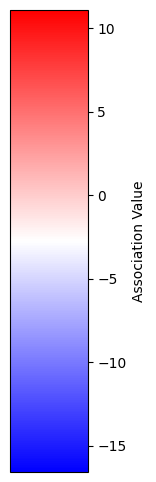

In [53]:
generate_colorbar(df_cd, '../../figures/colorbar.png')

In [ ]:
plot_network(cluster_ids, significant_edges, df_uc, merged_df)